In [1]:
!pip install opencv-python opencv-python-headless

Image loaded successfully!


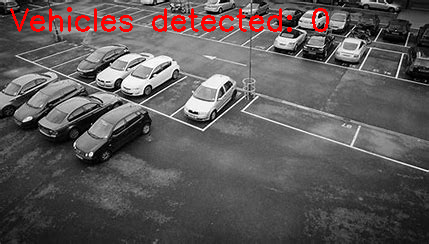

Final Vehicle Count: 0


In [13]:
import cv2
import numpy as np

# Load YOLO model
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
with open("coco.names", "r") as f:
    classes = f.read().strip().split("\n")

# Load image
image_path = "/content/OIP.jpeg"  # Update path if needed
image = cv2.imread(image_path)

if image is None:
    print("Error: Image not found or could not be loaded.")
else:
    print("Image loaded successfully!")
    height, width, _ = image.shape

    # Prepare image for YOLO
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    # Get output layer names
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    # Perform detection
    detections = net.forward(output_layers)

    # Process detections
    vehicle_count = 0
    boxes, confidences, class_ids = [], [], []

    for output in detections:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            # Consider only vehicles (car, bus, truck, motorcycle)
            if confidence > 0.5 and class_id in [2, 3, 5, 7]:
                vehicle_count += 1

                # Get bounding box coordinates
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply Non-Maximum Suppression (NMS) to remove duplicate detections
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    final_count = len(indices)

    for i in indices:
        i = i[0]
        x, y, w, h = boxes[i]
        label = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"
        color = (0, 255, 0)  # Green for bounding box
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display vehicle count on image
    text = f"Vehicles detected: {final_count}"
    cv2.putText(image, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Show the image in Colab
    from google.colab.patches import cv2_imshow
    cv2_imshow(image)

    print(f"Final Vehicle Count: {final_count}")
